# Inspired from work by Jencka and Adams

In [46]:
import pandas as pd
import seaborn as sns
from scipy import signal
from matplotlib import pyplot as plt
import matplotlib.patheffects as pe
import numpy as np

In [47]:
header = ("X", "Y", "Z", "TIME", "SLURM_NNODES", "SLURM_NTASKS_PER_NODE", "OMP_NUM_THREADS", "SLURM_GPUS_PER_NODE", "GFLOPS")

In [48]:
dat_hopper = pd.read_csv('global_results.csv', names=header)
dat_hopper = dat_hopper.dropna()
dat_hopper['Cluster'] = 'Hopper'
dat_hopper.loc[dat_hopper['SLURM_GPUS_PER_NODE'] > 0, 'Cluster'] = "Hopper (GPU)"

In [49]:
# Trim initial malformed results
dat_hopper = dat_hopper.iloc[1185:]

In [50]:
data = pd.concat((dat_hopper,))
data

,X,Y,Z,TIME,SLURM_NNODES,SLURM_NTASKS_PER_NODE,OMP_NUM_THREADS,SLURM_GPUS_PER_NODE,GFLOPS,Cluster
1185,8,8.0,8.0,90.0,1.0,2.0,1.0,2.0,0.014596,Hopper (GPU)
1186,8,8.0,32.0,90.0,1.0,2.0,1.0,2.0,0.028943,Hopper (GPU)
1187,8,8.0,56.0,90.0,1.0,2.0,1.0,2.0,0.050927,Hopper (GPU)
1188,8,8.0,8.0,90.0,4.0,1.0,1.0,1.0,5.508880,Hopper (GPU)
1189,8,8.0,32.0,90.0,4.0,1.0,1.0,1.0,10.878000,Hopper (GPU)
...,...,...,...,...,...,...,...,...,...,...
15109,56,64.0,56.0,90.0,2.0,1.0,16.0,0.0,3.956930,Hopper
15110,56,64.0,64.0,90.0,2.0,1.0,16.0,0.0,3.917500,Hopper
15111,56,64.0,72.0,90.0,2.0,1.0,16.0,0.0,3.887050,Hopper
15112,56,64.0,80.0,90.0,2.0,1.0,16.0,0.0,3.836170,Hopper


In [51]:
data['Process Count'] = data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'] * data['OMP_NUM_THREADS']
set(data['Process Count'])

{1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0}

In [52]:
data['Problem Size'] = data['X'] * data['Y'] * data['Z']
print(data['Problem Size'].max() ** (1.0 / 3.0))

data['Global Problem Size'] = data['Problem Size'] * ((data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE']) ** 3.0)
print(data['Global Problem Size'].max() ** (1.0 / 3.0))

82.30621182481418
2994.1941639299735


In [53]:
data['SLURM_GPUS_PER_NODE'].max()

2.0

In [54]:
data['OMP_NUM_THREADS'].max()

32.0

# Plots

In [55]:
def label_peaks(df, groupby, value, troughs=False):
    mean = df.groupby(groupby).mean(numeric_only=True)[value]
    idx, _ = signal.find_peaks(mean)
    peaks = mean.iloc[idx]

    if troughs:
        idx, _ = signal.find_peaks(-mean)
        peaks = pd.concat((peaks, mean.iloc[idx]))

    for (x, y) in peaks.items():
        plt.text(x, y, str(x), path_effects=[pe.withStroke(linewidth=4, foreground="white")])

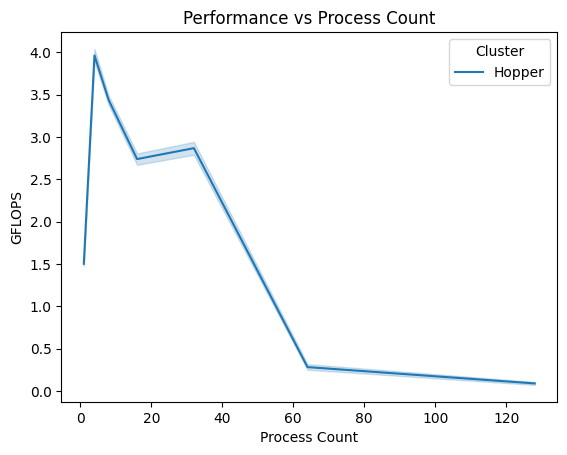

In [56]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count.svg')

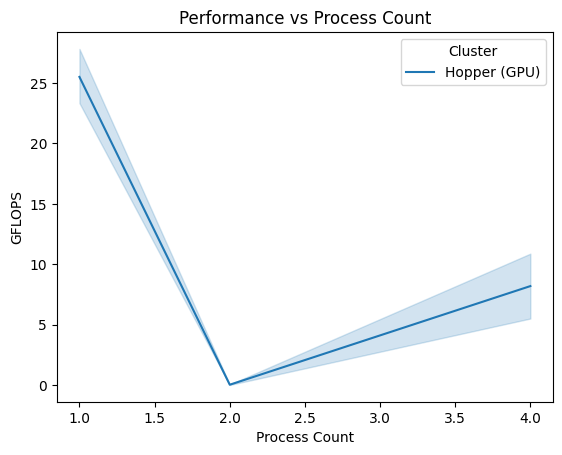

In [57]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Process Count", y="GFLOPS", hue='Cluster')
plt.title('Performance vs Process Count')
plt.savefig('figures/flops_process_count_gpu.svg')

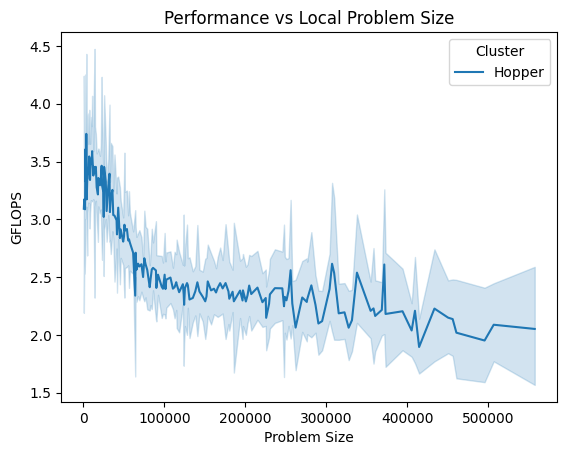

In [58]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Local Problem Size')
plt.savefig('figures/flops_local_problem_size.svg')

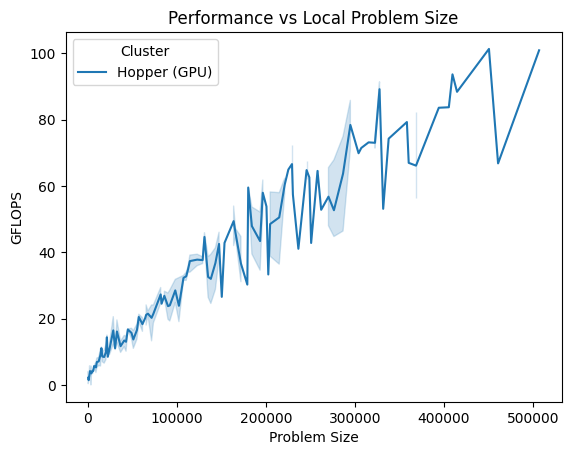

In [59]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Local Problem Size')
plt.savefig('figures/flops_local_problem_size_gpu.svg')

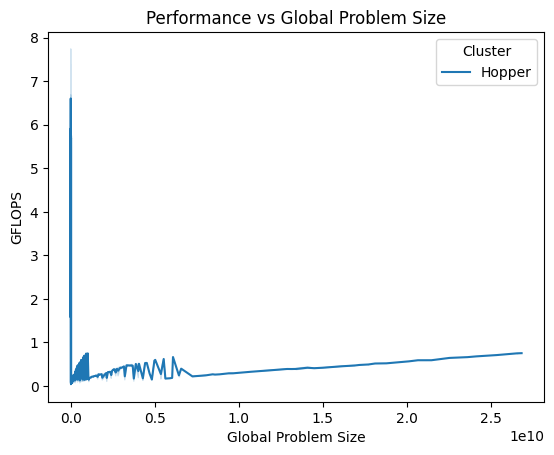

In [60]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Global Problem Size')
plt.savefig('figures/flops_global_problem_size.svg')

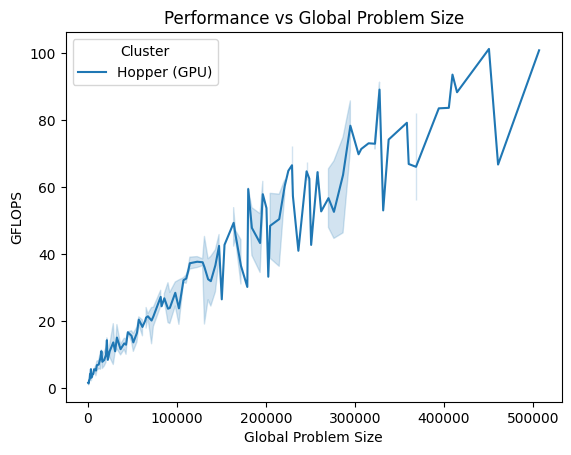

In [61]:
sns.lineplot(data[data['Cluster'] == 'Hopper (GPU)'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance vs Global Problem Size')
plt.savefig('figures/flops_global_problem_size_gpu.svg')

# Statistics

In [62]:
# Summary Stats for performance of ALL runs
stats_all_runs = data["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_all_runs

count    13928.000000
mean         3.421561
std          5.405129
min          0.014596
25%          1.794475
50%          2.663675
75%          3.685890
90%          5.474809
95%          6.275412
99%         26.266363
max        101.310000
Name: GFLOPS, dtype: float64

In [63]:
# Summary stats for Hopper
stats_hopper = data[data['Cluster'] == 'Hopper']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper

count    13545.000000
mean         2.805380
std          1.640147
min          0.019409
25%          1.760810
50%          2.630350
75%          3.501620
90%          5.057966
95%          5.791892
99%          8.661950
max         10.950000
Name: GFLOPS, dtype: float64

In [64]:
# Summary stats for Hopper (GPU)
stats_hopper_gpu = data[data['Cluster'] == 'Hopper (GPU)']["GFLOPS"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
stats_hopper_gpu

count    383.000000
mean      25.213124
std       21.913076
min        0.014596
25%        8.216705
50%       17.441700
75%       35.368650
90%       59.881040
95%       69.862730
99%       88.925212
max      101.310000
Name: GFLOPS, dtype: float64

In [65]:
# latex
print(pd.concat([stats_all_runs, stats_hopper, stats_hopper_gpu], axis=1).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &        GFLOPS &        GFLOPS &      GFLOPS \\
\midrule
count &  13928.000000 &  13545.000000 &  383.000000 \\
mean  &      3.421561 &      2.805380 &   25.213124 \\
std   &      5.405129 &      1.640147 &   21.913076 \\
min   &      0.014596 &      0.019409 &    0.014596 \\
25\%   &      1.794475 &      1.760810 &    8.216705 \\
50\%   &      2.663675 &      2.630350 &   17.441700 \\
75\%   &      3.685890 &      3.501620 &   35.368650 \\
90\%   &      5.474809 &      5.057966 &   59.881040 \\
95\%   &      6.275412 &      5.791892 &   69.862730 \\
99\%   &     26.266363 &      8.661950 &   88.925212 \\
max   &    101.310000 &     10.950000 &  101.310000 \\
\bottomrule
\end{tabular}



# Gustafson's like

In [66]:
one_thread = data[data['OMP_NUM_THREADS'] == 1]

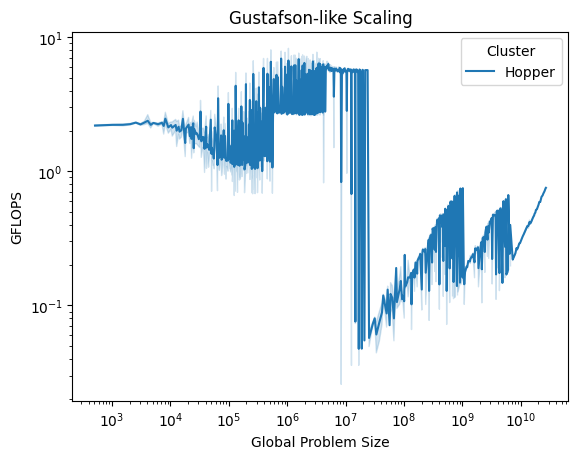

In [67]:
sns.lineplot(one_thread[one_thread['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson.svg')

In [68]:
past_3e6 = one_thread[one_thread['Global Problem Size'] > .25e10]

In [69]:
pre_3e6 = one_thread[one_thread['Global Problem Size'] < 1e9]

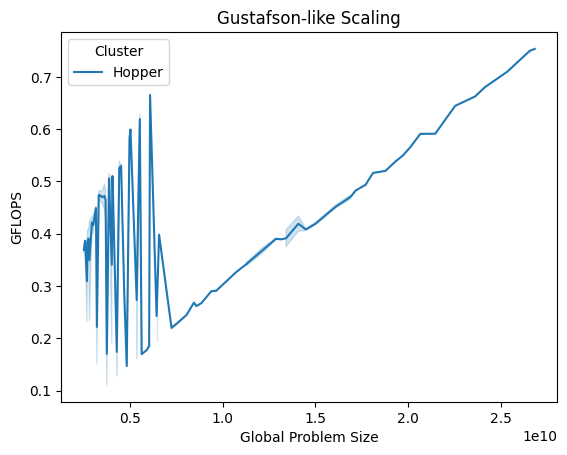

In [70]:
sns.lineplot(past_3e6[past_3e6['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_big.svg')

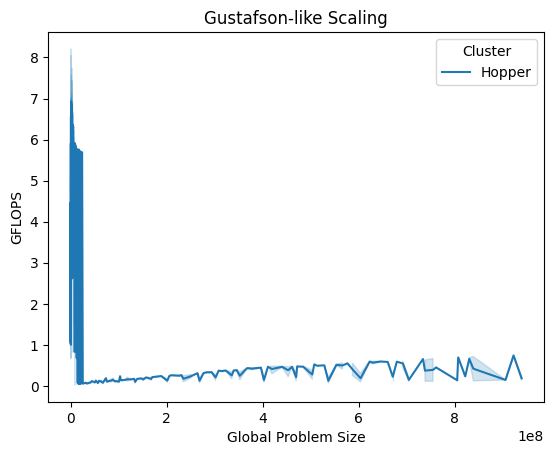

In [71]:
sns.lineplot(pre_3e6[pre_3e6['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_small.svg')

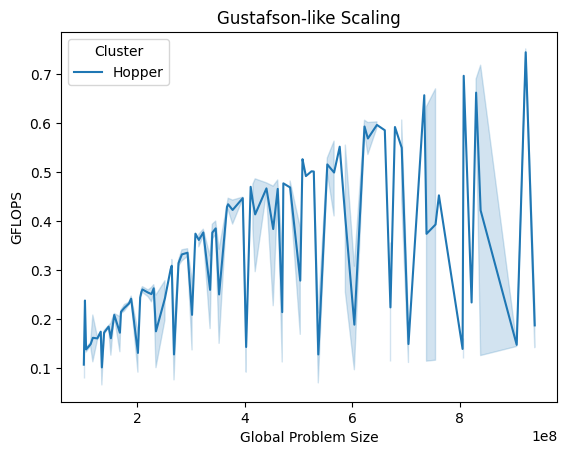

In [72]:
cutlow = pre_3e6[pre_3e6['Global Problem Size'] > 1e8]
sns.lineplot(cutlow[cutlow['Cluster'] == 'Hopper'], x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.title('Gustafson-like Scaling')
plt.savefig('figures/flops_gustafson_small_cutlow.svg')

# Cubic

In [73]:
local_cube_root = data['Problem Size'].pow(1.0 / 3.0)
global_cube_root = data['Global Problem Size'].pow(1.0 / 3.0)
data["Local close to cube"] = np.sqrt(((local_cube_root - data['X']) ** 2.0) + ((local_cube_root - data['Y']) ** 2.0) + ((local_cube_root - data['Z']) ** 2.0))
data["Global close to cube"] = np.sqrt(((global_cube_root - (data['X'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0) + \
                                        ((global_cube_root - (data['Y'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0) + \
                                        ((global_cube_root - (data['Z'] * data['SLURM_NNODES'] * data['SLURM_NTASKS_PER_NODE'])) ** 2.0))

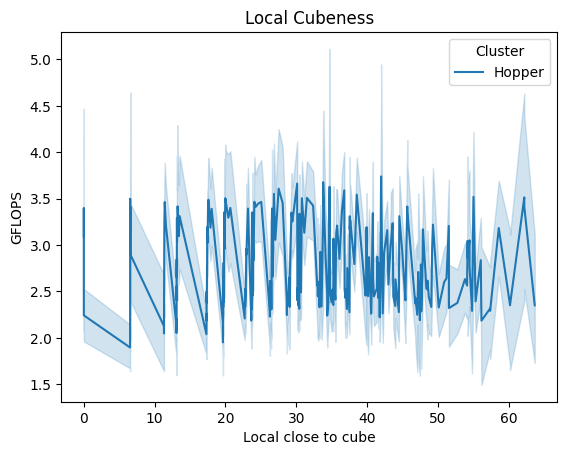

In [74]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Local close to cube", y="GFLOPS", hue='Cluster')
#plt.xscale('log')
#plt.yscale('log')
plt.title('Local Cubeness')
plt.savefig('figures/flops_cubeness_local.svg')

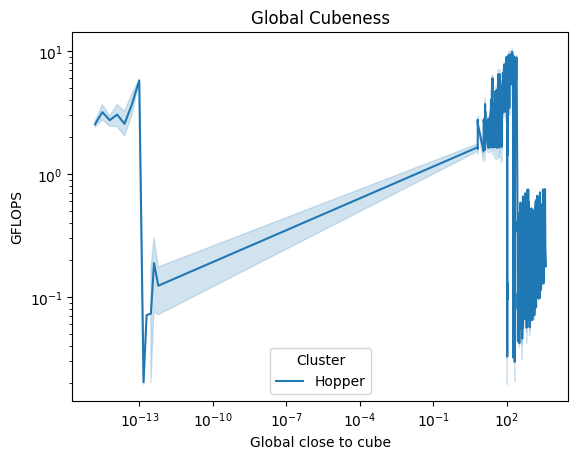

In [75]:
sns.lineplot(data[data['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global.svg')

In [76]:
past_500 = data[data['Global close to cube'] > 500]
pre_300 = data[data['Global close to cube'] < 300]

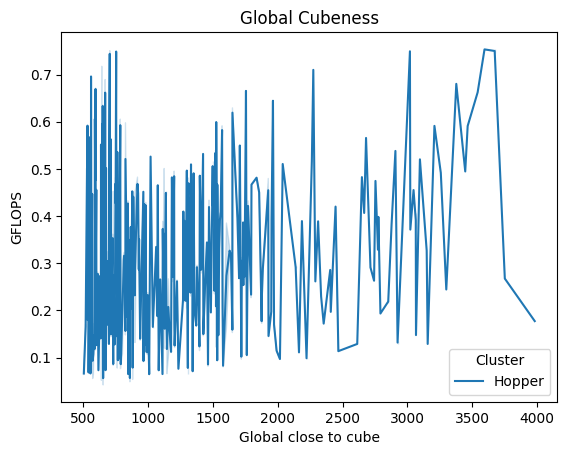

In [77]:
sns.lineplot(past_500[past_500['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global_large.svg')

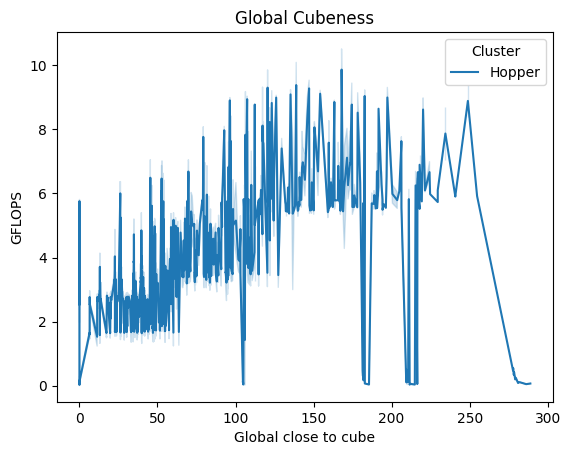

In [78]:
sns.lineplot(pre_300[pre_300['Cluster'] == 'Hopper'], x="Global close to cube", y="GFLOPS", hue='Cluster')
plt.title('Global Cubeness')
plt.savefig('figures/flops_cubeness_global_small.svg')

# CPU vs GPU

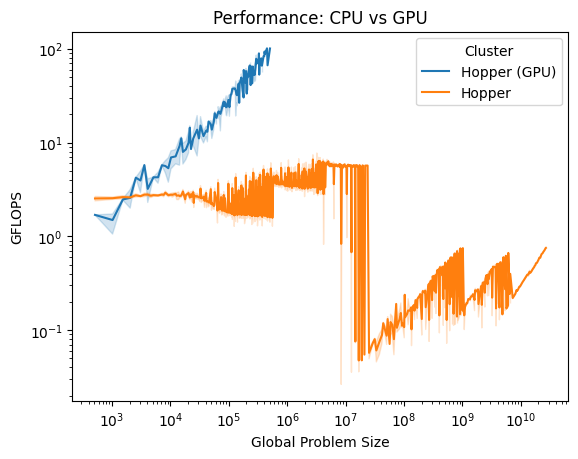

In [79]:
sns.lineplot(data, x="Global Problem Size", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance: CPU vs GPU')
plt.savefig('figures/flops_global_problem_size_cpu_vs_gpu.svg')

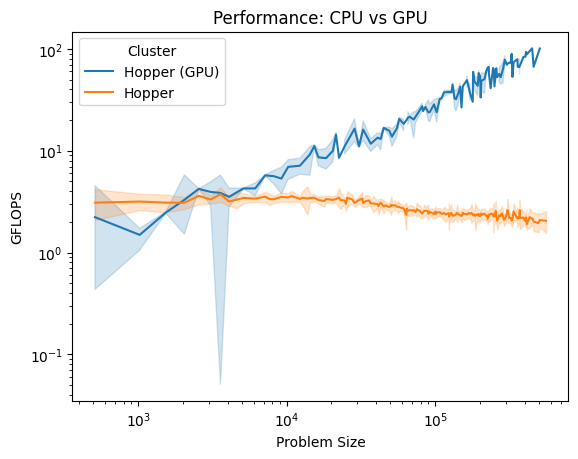

In [80]:
sns.lineplot(data, x="Problem Size", y="GFLOPS", hue='Cluster')
plt.xscale('log')
plt.yscale('log')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Performance: CPU vs GPU')
plt.savefig('figures/flops_local_problem_size_cpu_vs_gpu.svg')

# Ahmdal-like

In [81]:
data_cpu = data[data['Cluster'] == 'Hopper']
data_cpu_one_task_per_node = data_cpu[data_cpu['SLURM_NTASKS_PER_NODE'] == 1]

data_up_to_x_nodes = data_cpu_one_task_per_node[data_cpu_one_task_per_node['SLURM_NNODES'] <= 2]

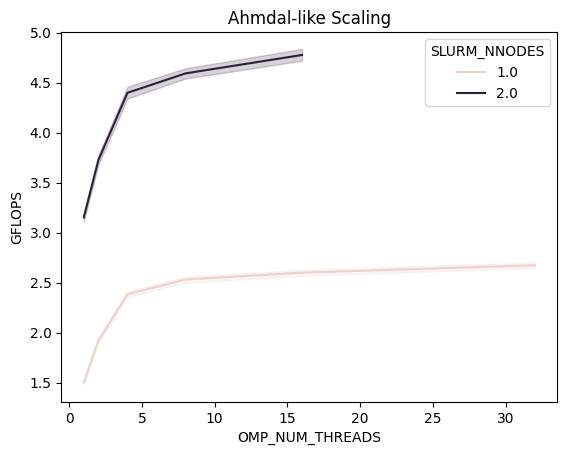

In [82]:
sns.lineplot(data_up_to_x_nodes, x="OMP_NUM_THREADS", y="GFLOPS", hue='SLURM_NNODES')
#plt.xscale('log')
#plt.yscale('log')
#label_peaks(data[data['Cluster'] == 'Hopper'], "Problem Size", "GFLOPS", True)
plt.title('Ahmdal-like Scaling')
plt.savefig('figures/flops_ahmdal.svg')

# Parameter combinations

In [104]:
param_sets = []
for name in header:
    vals = data[name].unique()
    vals.sort()
    param_sets.append(vals.astype(int))

In [105]:
param_sets = param_sets[:-1]

In [106]:
param_strings = []
for set in param_sets:
    st = ""
    for pv in set:
        st = st + str(pv) + ", "
    param_strings.append(st[:-2])

In [107]:
param_df = pd.DataFrame(param_strings)

In [108]:
param_df.insert(0, "", header[:-1])

In [109]:
print(param_df.to_latex())

\begin{tabular}{lll}
\toprule
{} &                                          0 \\
\midrule
0 &                      X &          8, 16, 24, 32, 40, 48, 56, 64, 72 \\
1 &                      Y &  8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88 \\
2 &                      Z &  8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88 \\
3 &                   TIME &                                         90 \\
4 &           SLURM\_NNODES &                                    1, 2, 4 \\
5 &  SLURM\_NTASKS\_PER\_NODE &                               1, 2, 16, 32 \\
6 &        OMP\_NUM\_THREADS &                         1, 2, 4, 8, 16, 32 \\
7 &    SLURM\_GPUS\_PER\_NODE &                                    0, 1, 2 \\
\bottomrule
\end{tabular}

